<a href="https://colab.research.google.com/github/eischaire/Distributional-Model-for-Semantic-Disambiguation/blob/master/Graphs_and_Scatter_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations; imports; assignments of imported preprocessing tools

In [0]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 7.1MB 4.2MB/s 


In [0]:
import re
import os
import json
import pymorphy2
from collections import defaultdict
from collections import Counter
import nltk
from nltk.corpus import stopwords
from math import sqrt
from __future__ import print_function
import time 
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.readwrite import json_graph
from tqdm import tqdm

nltk.download('stopwords')
stop_words = stopwords.words('russian')

lem = pymorphy2.MorphAnalyzer()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Collecting texts to /content

In [0]:
# !wget http://lib.ru/DOWLATOW/kompromiss.txt
# !wget http://lib.ru/PROZA/WAJLGENIS/genij.txt
# !wget http://lib.ru/RBACH/award.txt
# !wget http://lib.ru/WELLER/dovlatov.txt
# !wget http://lib.ru/PROZA/ORLOW_O/nikolsk.txt
# !wget http://lib.ru/NEWPROZA/RUBINA/venice.txt
# !wget http://lib.ru/PROZA/DOMBROWSKIJ/faculty.txt

## Preprocessing functions

In [0]:
def read_file(path, enc):
  """
  Extracts a text from a file that is found by a given path.

  :path: str
  :enc: str, file encoding

  :output: str, raw text from the file
  """
  with open(path, 'r', encoding=enc) as f:
    text = f.read()
  
  return text

In [0]:
def clean_text(text, tags_in_text=True):
  """
  Cleans raw text from brackets, tags, and extra characters.
  Returns the cleaned text in lowercase.

  :text: str
  :tags_in_text: bool, whether html tags occur in the raw text
  
  :output: str, lowercase cleaned text
  """
  text = re.sub('\r\n', '\n', text)
  if tags_in_text == True:
    text = re.sub('\[.+?\]\n?', '', text)
    text = re.sub('\<.+?\>', '', text, flags=re.DOTALL)
    text = re.sub('\&.+?; ?', '', text)
  text = re.sub('(\n +?)+', '\n', text)
  text = re.sub('(\n +)+', ' ', text)
  text = re.sub('\n', ' ', text)
  text = text.lower()

  return text

In [0]:
def lemmatize(text, remove_stopwords=False):
  """
  Returns a list of lemmas in the order of their occurrence in the text.

  :text: str

  :output: list, lemmatized words from the text
  """
  words = re.findall('([а-я1-9]+)', text)
  lemmas = [lem.parse(word)[0].normal_form for word in words]
  if remove_stopwords == True:
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words]
  return lemmas

In [0]:
def collocations(lemma_lists, min_count=5):
  """
  Makes a dictionary of frequently occurring collocations from the whole corpus
  and their occurrence counts.

  :lemma_lists: list of lists of lemmas from each document in a corpus
  :min_count: int, minimum collocation occurrence count 
  to be accommodated in the model

  :output: dict of dicts, frequent collocation counts in a corpus
  """
  word_corpus = [lemma for l_list in lemma_lists for lemma in l_list]
  word_counts = Counter(word_corpus)
  lemmas_colloc = {}
  for lemmas in lemma_lists:
    for i in range(len(lemmas)):
      if lemmas[i] not in lemmas_colloc:
        lemmas_colloc[lemmas[i]] = defaultdict(int)
      for j in range(-5,6):
        if i+j >= 0 and j != 0 and i+j < len(lemmas):
          lemmas_colloc[lemmas[i]][lemmas[i+j]] += 1

  frequent_colloc = defaultdict(dict)
  for coll in lemmas_colloc:
    for sec in lemmas_colloc[coll]:
      if lemmas_colloc[coll][sec] >= min_count:
        frequent_colloc[coll][sec] = lemmas_colloc[coll][sec]

  return dict(frequent_colloc)

In [0]:
def extract_lemma_list(path, encoding, tags_in_text=True, remove_stopwords=False):
  """
  Extracts text from the file found by a given path, and 
  makes a list of lemmatized words in the order of their
  occurrence in the text. 

  :path: str
  :encoding: str
  :tags_in_text: bool
  :remove_stopwords: bool

  :output: list of lemmas
  """
  raw = read_file(path, encoding)
  text = clean_text(raw, tags_in_text)
  lemma_list = lemmatize(text, remove_stopwords)
  
  return lemma_list

In [0]:
def extend_corpus(path_list, encoding_list, tagged_list, remove_stopwords=False, corpus=[]):
  """
  Blah/

  :path_list: list of strings. each element is a path for a file
  :encoding_list: list of strings. encoding_list[i] is the encoding of the file found by path_list[i]
  :tagged_list: list of bools. tagged_list[i] shows whether html tags occur in the text in path_list[i]
  :remove_stopwords: bool
  :corpus: list of lists of lemmas if other documents were already added to the corpus

  :output: list of lists of lemmas, the extended corpus

  """
  for i in range(len(path_list)):
    path = path_list[i]
    enc = encoding_list[i]
    tags = tagged_list[i]
    lemma_list = extract_lemma_list(path, enc, tags, remove_stopwords)
    corpus.append(lemma_list)
  return corpus

## preprocessing corpus

In [0]:
lemma_lists = []

In [0]:
path_list = ['dovlatov (1).txt', 'genij (2).txt', 'kompromiss.txt', 'nikolsk (1).txt', 'award.txt', 'venice.txt', 'faculty.txt']
enc_list = ['koi8-r', 'cp1251'] + ['koi8-r'] * 5
tagged = [True] * 7
lemma_lists = extend_corpus(path_list, enc_list, tagged, remove_stopwords=True, corpus=[])

In [0]:
full_corp = [lemma for llist in lemma_lists for lemma in llist]
lemma_count = Counter(full_corp)

In [0]:
print(len(full_corp))
print(len(lemma_count))

341266
34508


## building co-occurrence frequency dictionary

In [0]:
freq_colloc = collocations(lemma_lists, min_count=5)

In [0]:
len(freq_colloc)

3942

## building vectors

In [0]:
pilot_colloc = {}
for key in freq_colloc:
  pilot_colloc[key] = list(freq_colloc[key].keys())

In [0]:
neighbors = [word for item in list(pilot_colloc.values()) for word in item]
dims = []
for word in neighbors:
  if word not in dims:
    dims.append(word)
print(len(dims))

3942


In [0]:
vec_dic = {}
for key in freq_colloc:
  vec = []
  for word in dims:
    val = 0
    if word in freq_colloc[key]:
      val = freq_colloc[key][word]
    vec.append(val)
  vec_dic[key] = vec
print(len(vec_dic))

3942


In [0]:
try:
  for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)
except Exception:
  pass

## building cosine distance matrix

In [0]:
distance_matrix = {}
for key in tqdm(sorted(freq_colloc.keys())):
  vec = []
  for word in sorted(freq_colloc.keys()):
    val = 10 * cosine(vec_dic[key], vec_dic[word])
    if val < 0:
      val = 0
    vec.append(val)
  distance_matrix[key] = vec
print(len(distance_matrix))

100%|██████████| 3942/3942 [3:18:24<00:00,  3.02s/it]

3942


## finding test words in the model vocabulary

In [0]:
with open('colors_yo.txt', 'r', encoding='utf-8') as f:
  colors = [word.strip('\n').lower() for word in f.readlines()]

with open('materials.txt', 'r', encoding='utf-8') as f:
  mat = [word.strip('\n').lower() for word in f.readlines()]

In [0]:
one_word_colors = []
for word in colors:
  if ' ' in word or '-' in word:
    continue
  one_word_colors.append(word.strip('\n'))

print(len(one_word_colors))

104


In [0]:
corpus_color = {}
for word in one_word_colors:
  if word in vec_dic:
    print(word)
    corpus_color[word] = vec_dic[word]
print(len(corpus_color))

corpus_mat = {}
for word in mat:
  if word in vec_dic:
    print(word)
    corpus_mat[word] = vec_dic[word]
print(len(corpus_mat))

чёрный
синий
бронзовый
коричневый
коричневый
медный
кукурузный
кирпичный
золотой
серый
зелёный
оранжевый
розовый
красный
фиолетовый
белый
вино
жёлтый
17
золотой
медный
бронзовый
железный
деревянный
стеклянный
кирпичный
картонный
резиновый
9


## building the cosine distance dataframe

In [0]:
var1 = sorted(corpus_color.keys())
var2 = sorted(corpus_mat.keys())

corp_col_mat = []
for word in var1:
  if word in var2:
    print(word)
    corp_col_mat.append(word)

color2mat_visual = {}
for word in one_word_colors:
  if word in vec_dic and word not in corp_col_mat:
    color2mat_visual[word] = (vec_dic[word], 'color')
for word in mat:
  if word in vec_dic and word not in corp_col_mat:
    color2mat_visual[word] = (vec_dic[word], 'material')
for word in corp_col_mat:
  color2mat_visual[word] = (vec_dic[word], 'both')

len(color2mat_visual)

бронзовый
золотой
кирпичный
медный


22

In [0]:
def apply_label(word):
  label = 'other'
  if word in color2mat_visual:
    label = color2mat_visual[word][1]
  return label

In [0]:
X = []
y = sorted(distance_matrix.keys())
for word in y:
  X.append(distance_matrix[word])

X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

feat_cols = ['dim' + str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: apply_label(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

(3942, 3942)
(3942,)
Size of the dataframe: (3942, 3944)


## tSNE computations for the scatter plot

In [0]:
data_subset = df[feat_cols].values
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=500, n_iter=300, metric='precomputed')
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 3942 samples in 0.025s...
[t-SNE] Computed neighbors for 3942 samples in 0.859s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3942
[t-SNE] Computed conditional probabilities for sample 2000 / 3942
[t-SNE] Computed conditional probabilities for sample 3000 / 3942
[t-SNE] Computed conditional probabilities for sample 3942 / 3942
[t-SNE] Mean sigma: 0.754466
[t-SNE] KL divergence after 100 iterations with early exaggeration: 49.761711
[t-SNE] KL divergence after 300 iterations: 0.808124
t-SNE done! Time elapsed: 53.30392622947693 seconds


## making graph data dictionaries

In [0]:
corpus_adjacency_data = {}
keys = sorted(distance_matrix.keys())
for word in keys:
  adjacency_vec = []
  distance_vec = distance_matrix[word]
  for i in range(len(distance_vec)):
    val = 0
    if distance_vec[i] < 1 and keys[i] != word:
      val = 1
    adjacency_vec.append(val)
  corpus_adjacency_data[word] = adjacency_vec

In [0]:
graph_adj_data = {
            'nodes': [], 
            'directed': False, 
            'graph': [], 
            'multigraph': False, 
            'adjacency': []
            }
            
for key in keys:
  graph_adj_data['nodes'].append({'id': key})
  vec = corpus_adjacency_data[key]
  bounds = []
  for i in range(len(vec)):
    if vec[i] == 1:
      bounds.append({'id': keys[i]})
  graph_adj_data['adjacency'].append(bounds)

In [0]:
colormat_data = {
            'nodes': [], 
            'directed': False, 
            'graph': [], 
            'multigraph': False, 
            'adjacency': []
            }
for i in range(len(keys)):
  if keys[i] in colors or keys[i] in mat:
    colormat_data['nodes'].append(graph_adj_data['nodes'][i])
    colormat_data['adjacency'].append(graph_adj_data['adjacency'][i])
length = len(colormat_data['nodes'])
for i in range(length):
  for node in colormat_data['adjacency'][i]:
    if node not in colormat_data['nodes']:
      colormat_data['nodes'].append(node)
      colormat_data['adjacency'].append([colormat_data['nodes'][i]])

## converting data to graphs

In [0]:
corpus_graph = json_graph.adjacency_graph(graph_adj_data)

In [0]:
colormat_graph = json_graph.adjacency_graph(colormat_data)

## graph visualization

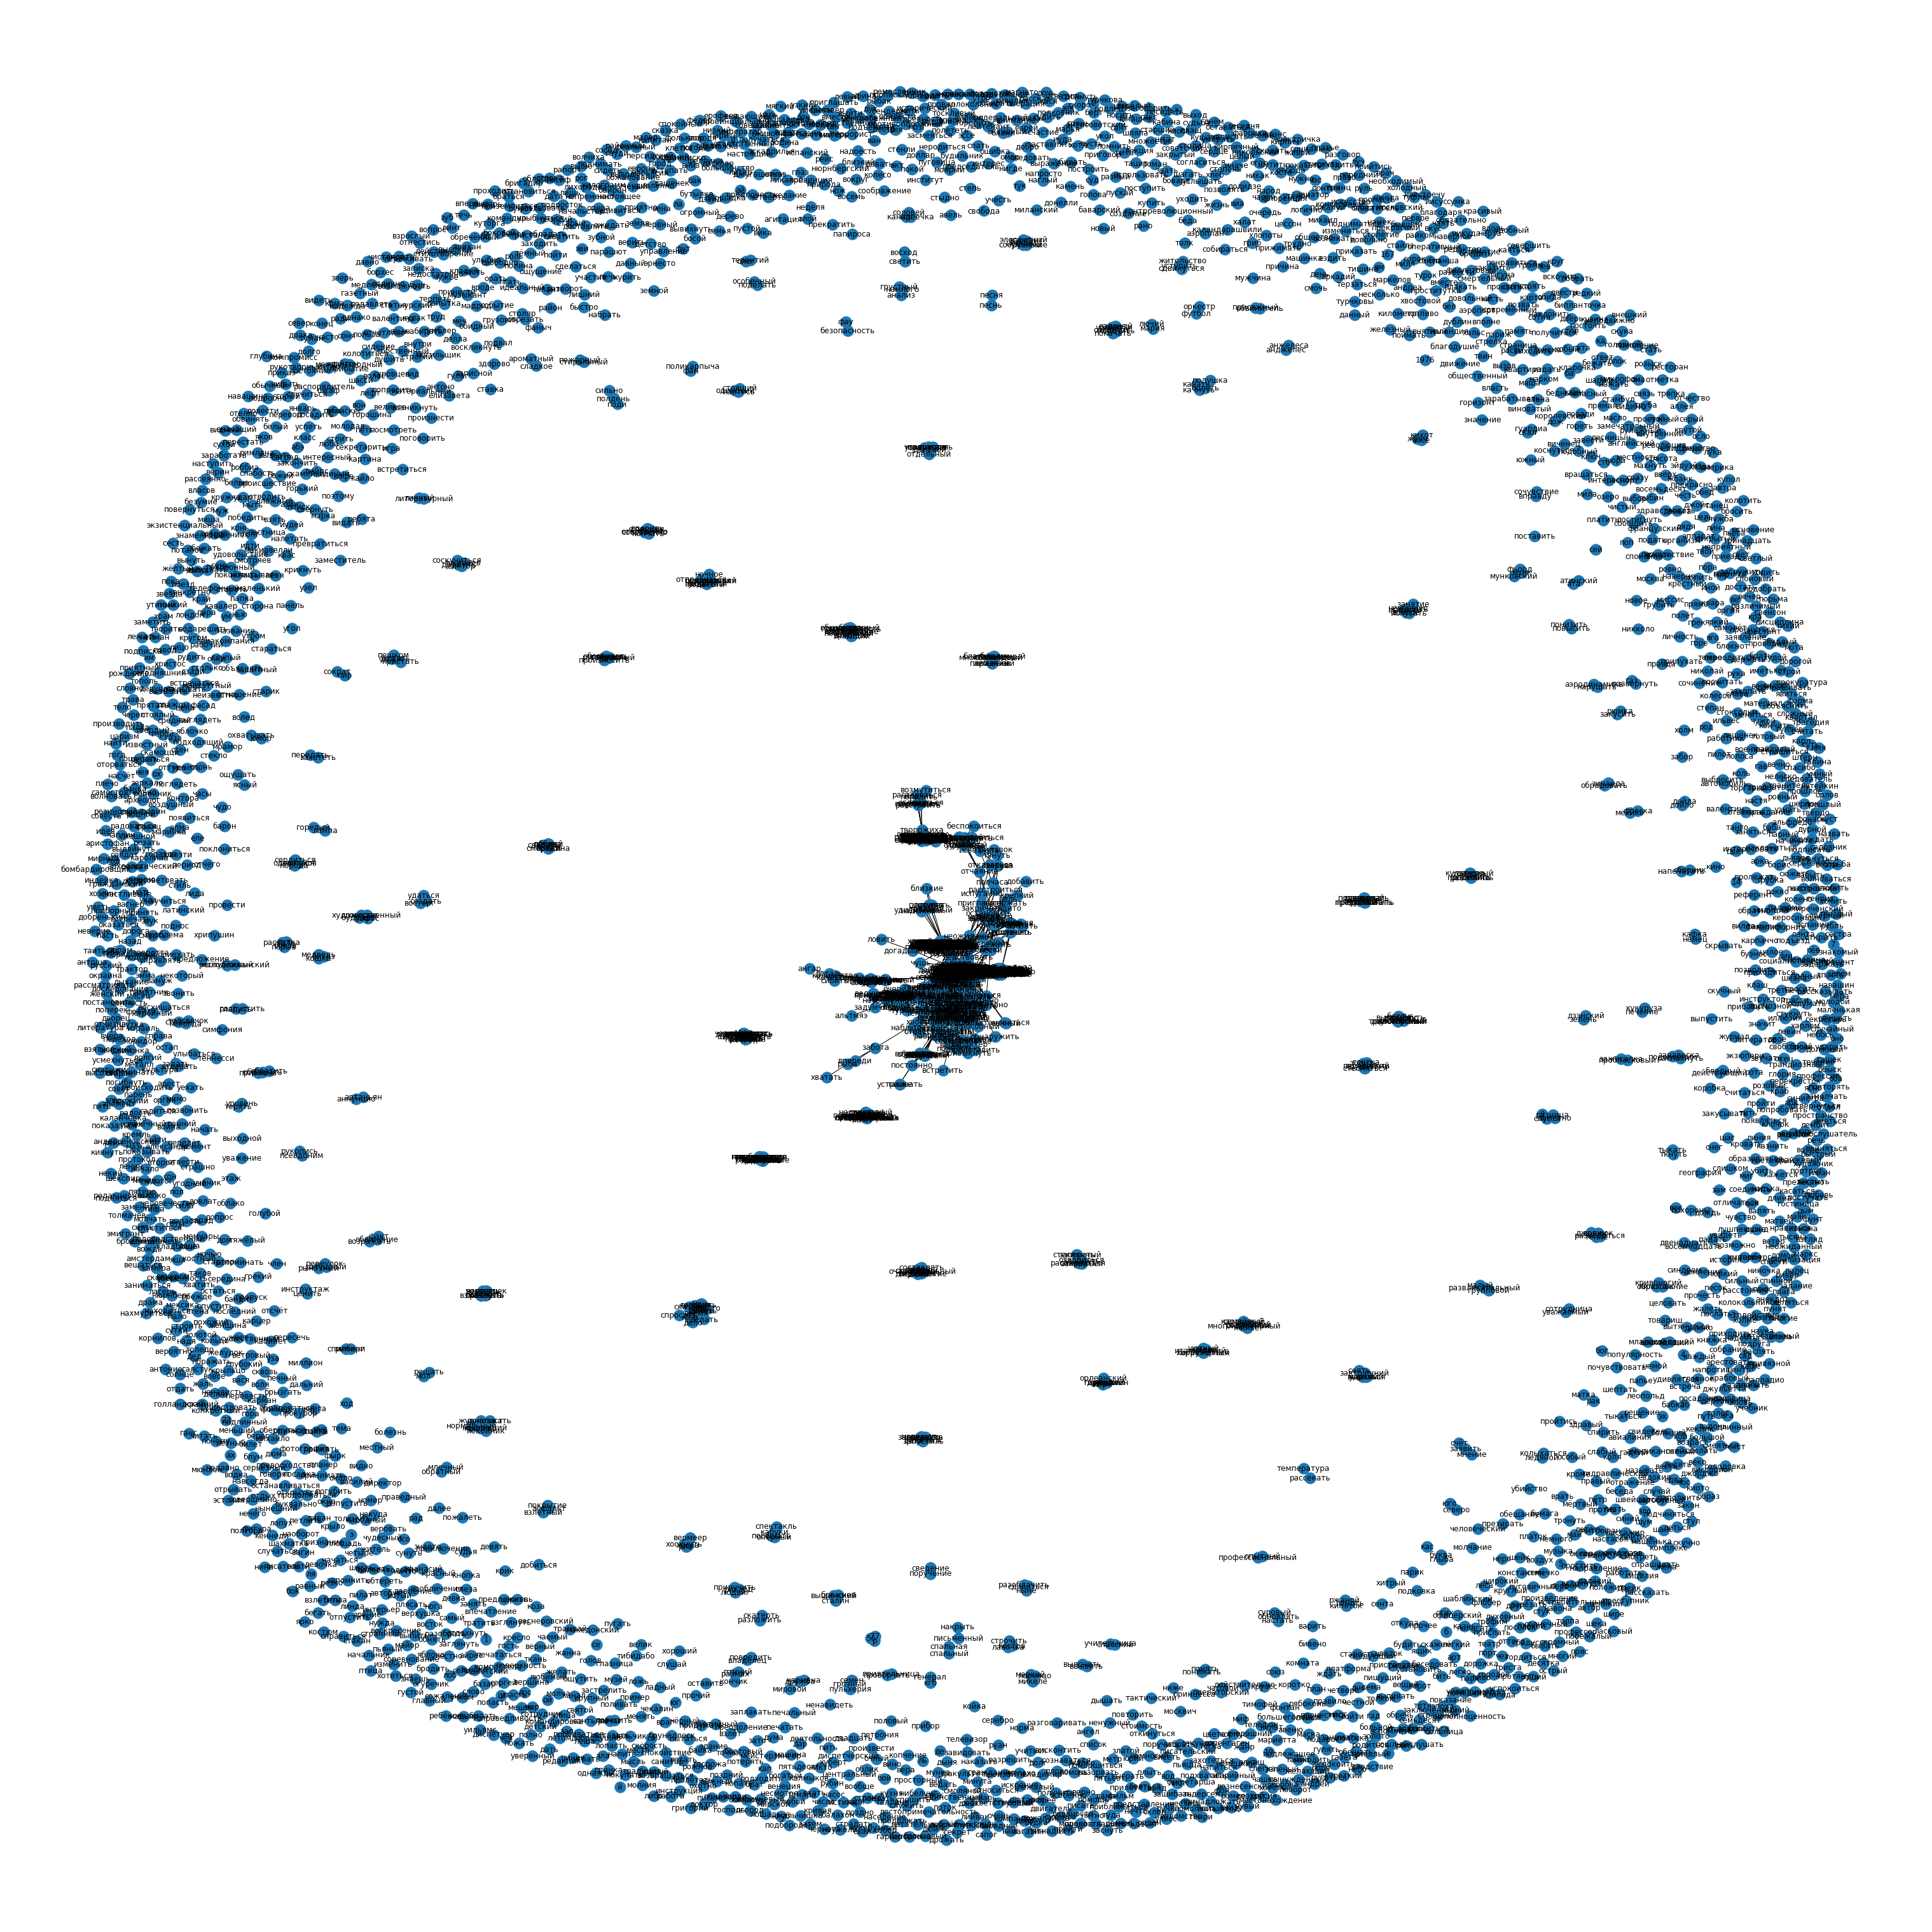

In [0]:
plt.figure(figsize=(42, 42))
nx.draw(corpus_graph, with_labels=True)
plt.show()

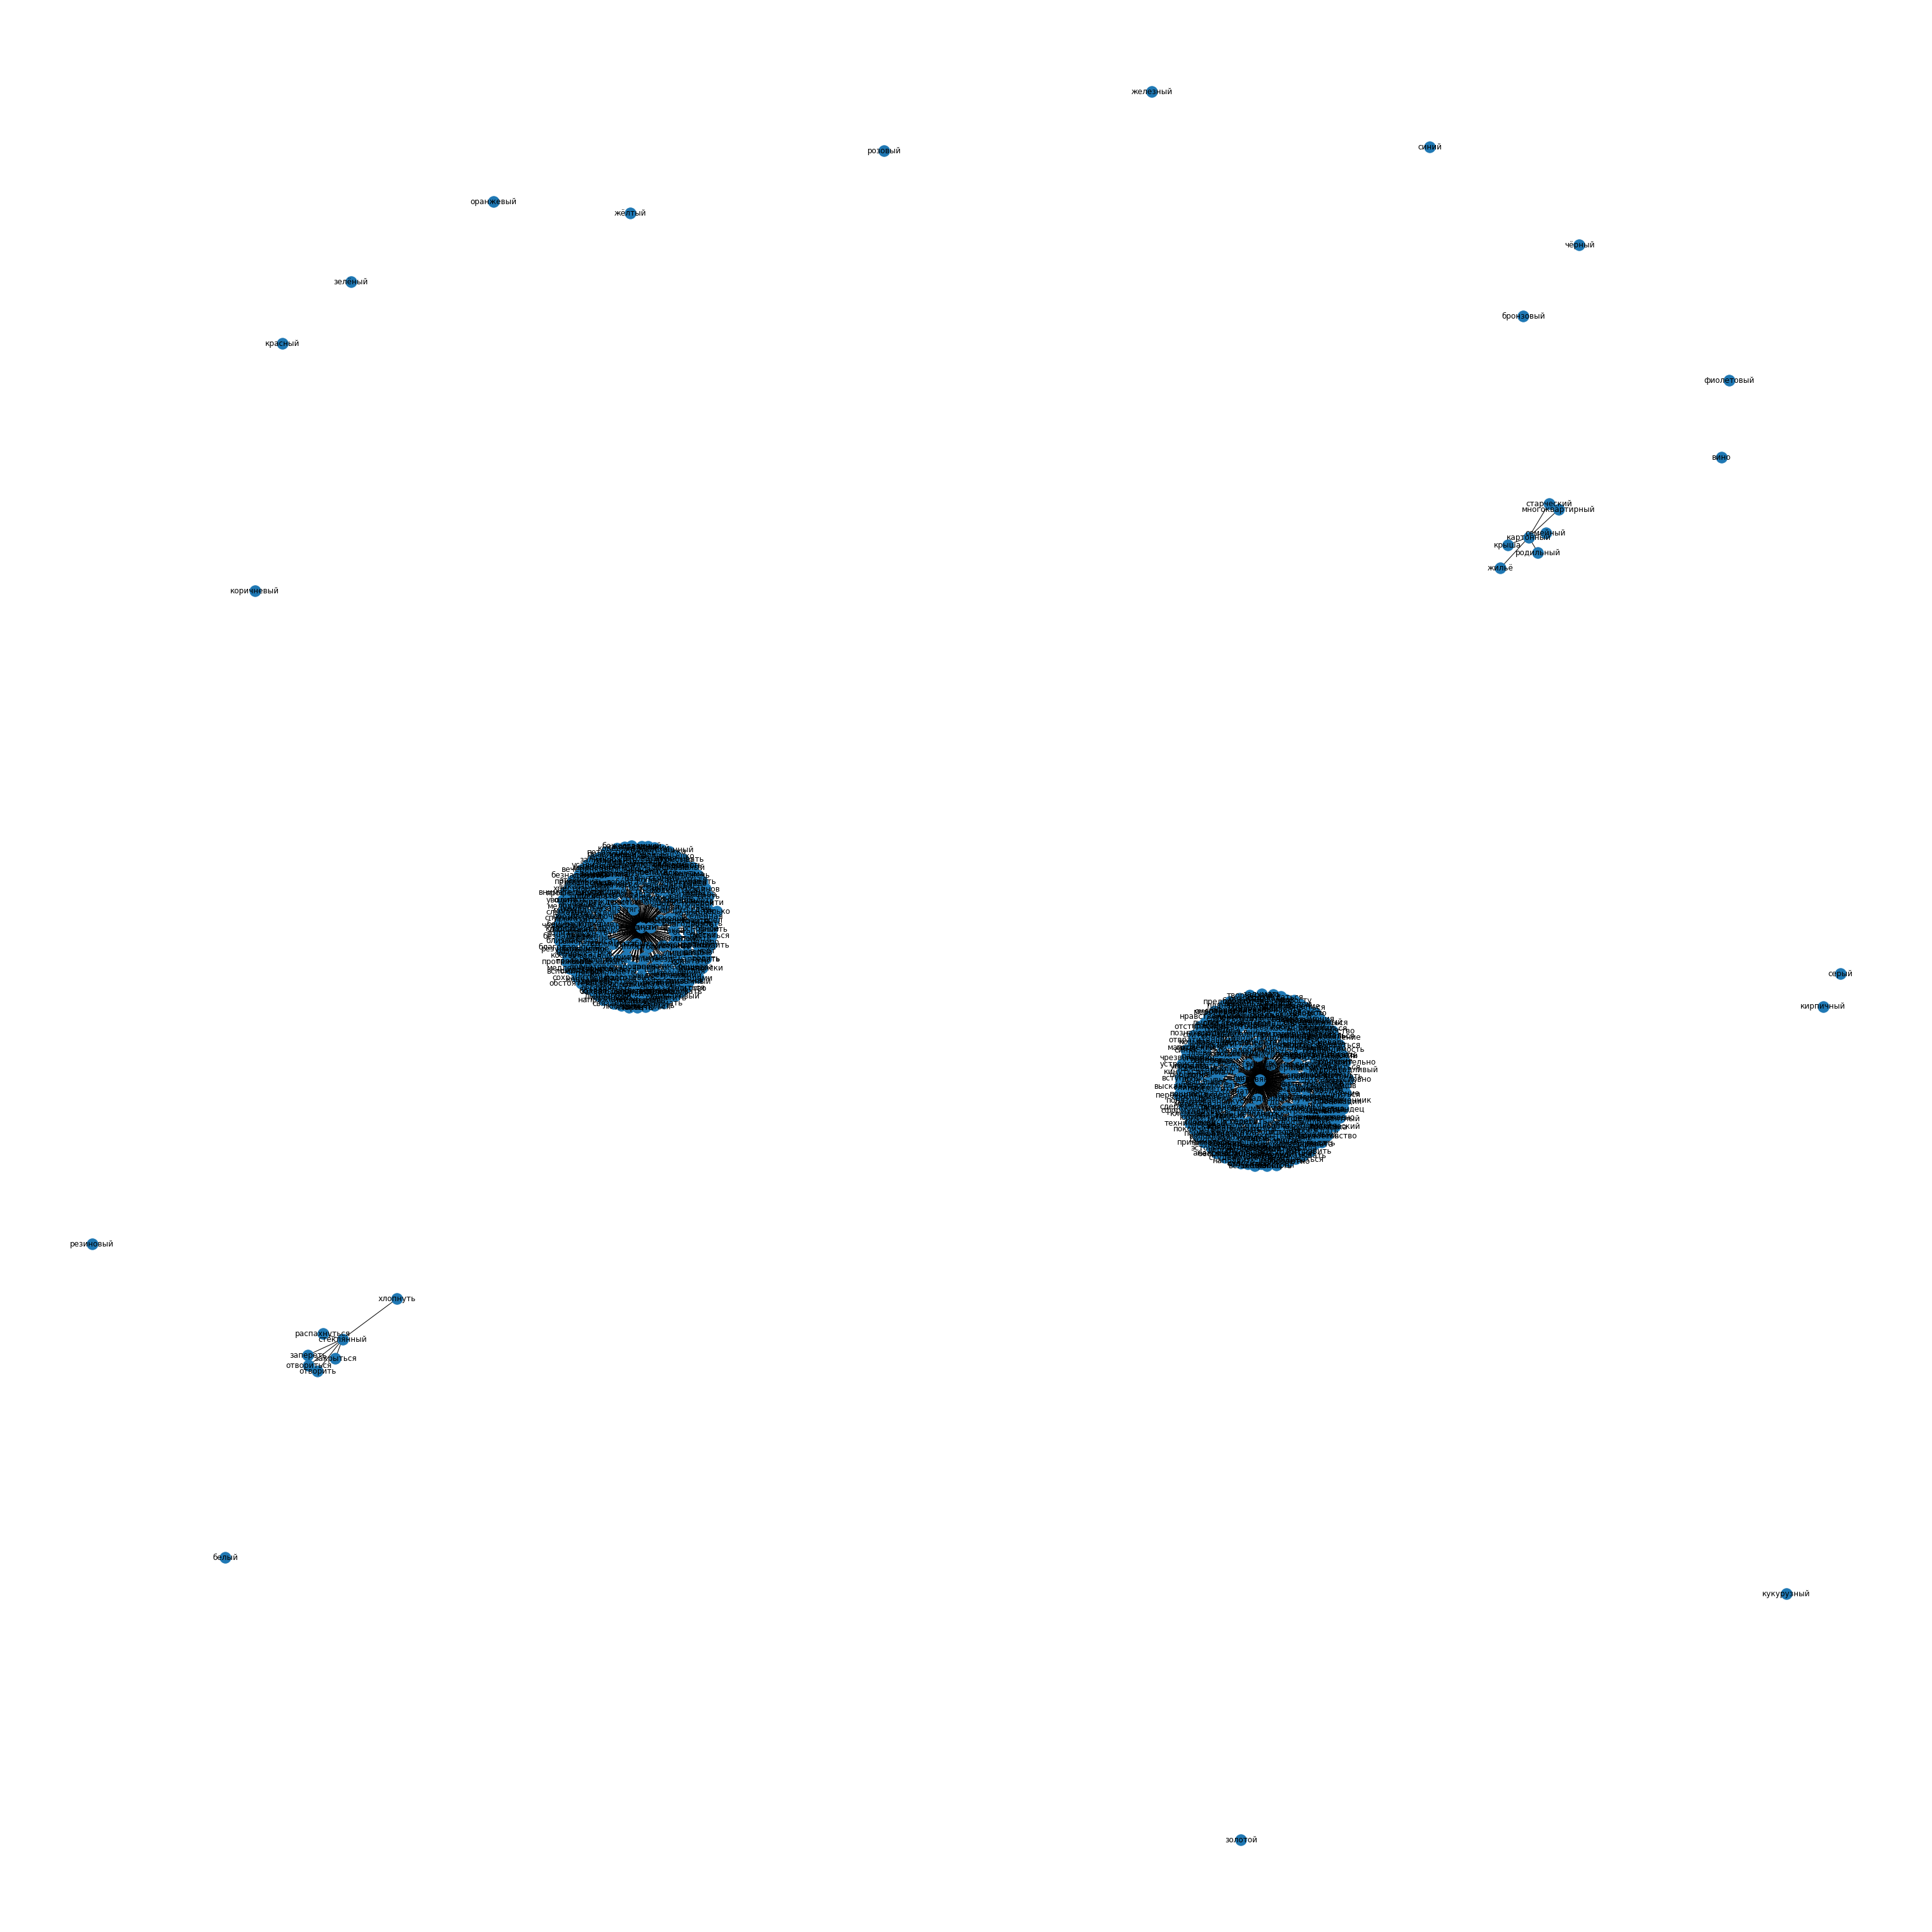

In [0]:
plt.figure(figsize=(42, 42))
nx.draw(colormat_graph, with_labels=True)
plt.show()

In [0]:
for word in color2mat_visual:
  print(word + ': ')
  print(freq_colloc[word])

чёрный: 
{'бела': 5, 'окно': 7, 'ничто': 6, 'свет': 5, 'синий': 7, 'рубаха': 6, 'шляпа': 9, 'слово': 8, 'ещё': 12, 'цвета': 7, 'чёрный': 58, 'брюки': 9, 'туфля': 8, 'уса': 5, 'кофе': 5, 'день': 7, 'море': 8, 'город': 5, 'белый': 30, 'небо': 9, 'сумка': 7, 'красный': 11, 'большой': 8, 'мор': 9, 'лицо': 15, 'коричневый': 6, 'зелёный': 14, 'это': 30, 'который': 11, 'цвет': 5, 'мочь': 8, 'весь': 36, 'розовый': 5, 'отец': 5, 'рука': 15, 'свисать': 5, 'носить': 5, 'белые': 18, 'смотреть': 6, 'увидеть': 5, 'жёлтый': 20, 'нужный': 5, 'лист': 6, 'дверь': 8, 'человек': 9, 'сказать': 13, 'глаз': 9, 'внутри': 5, 'фон': 7, 'внизу': 5, 'маленький': 5, 'кожа': 5, 'крест': 6, 'хлеб': 6, 'говорить': 6, 'худой': 6, 'голова': 5, 'огромный': 7, 'наш': 6, 'бровь': 5, 'хороший': 5, 'стоять': 6, 'думать': 5, 'свой': 8, 'вера': 9, 'платье': 6, 'высокий': 8, 'смородина': 5, 'настоящий': 6, 'дом': 6, 'падать': 6, 'красивый': 7, 'одетый': 9, 'самый': 10, 'двигатель': 7, 'стать': 5, 'приближаться': 5, 'мужчина': 

## scatter plot visualization

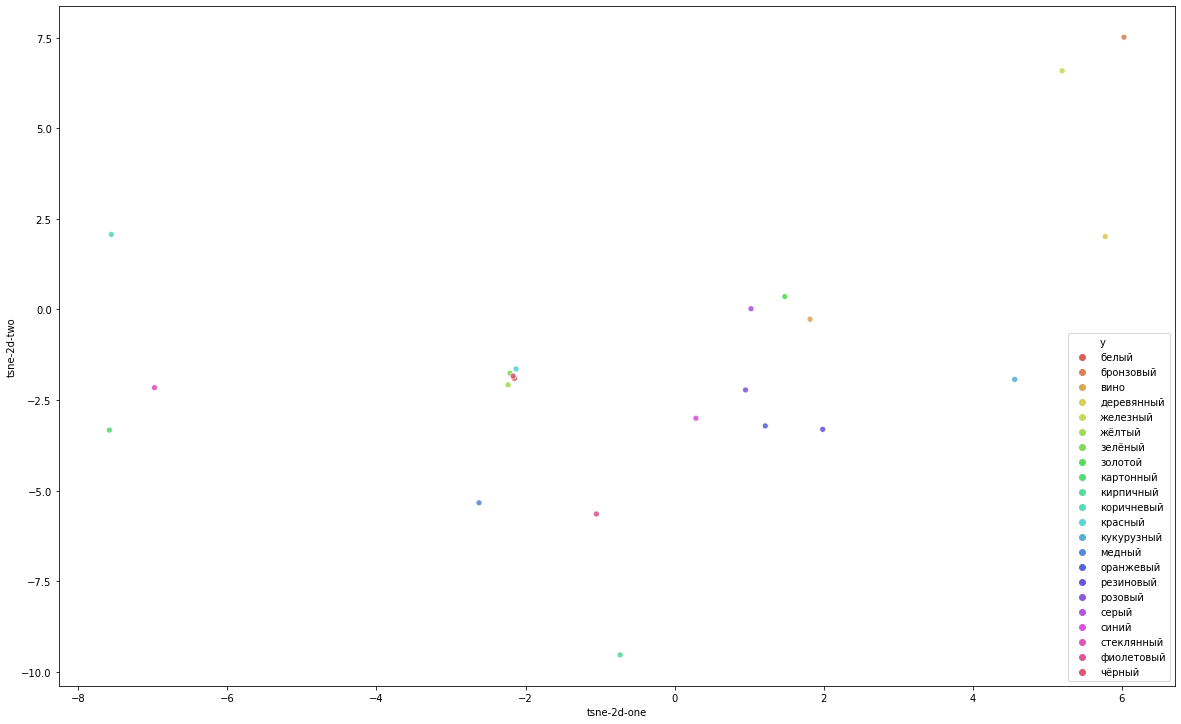

In [0]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df_for_plot = df[df.label != 'other']
plt.figure(figsize=(20,12.5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", df_for_plot.shape[0]),
    sizes=(2.5, 2.5, 2.5),
    data=df_for_plot,
    legend="brief",
    alpha=0.9
)

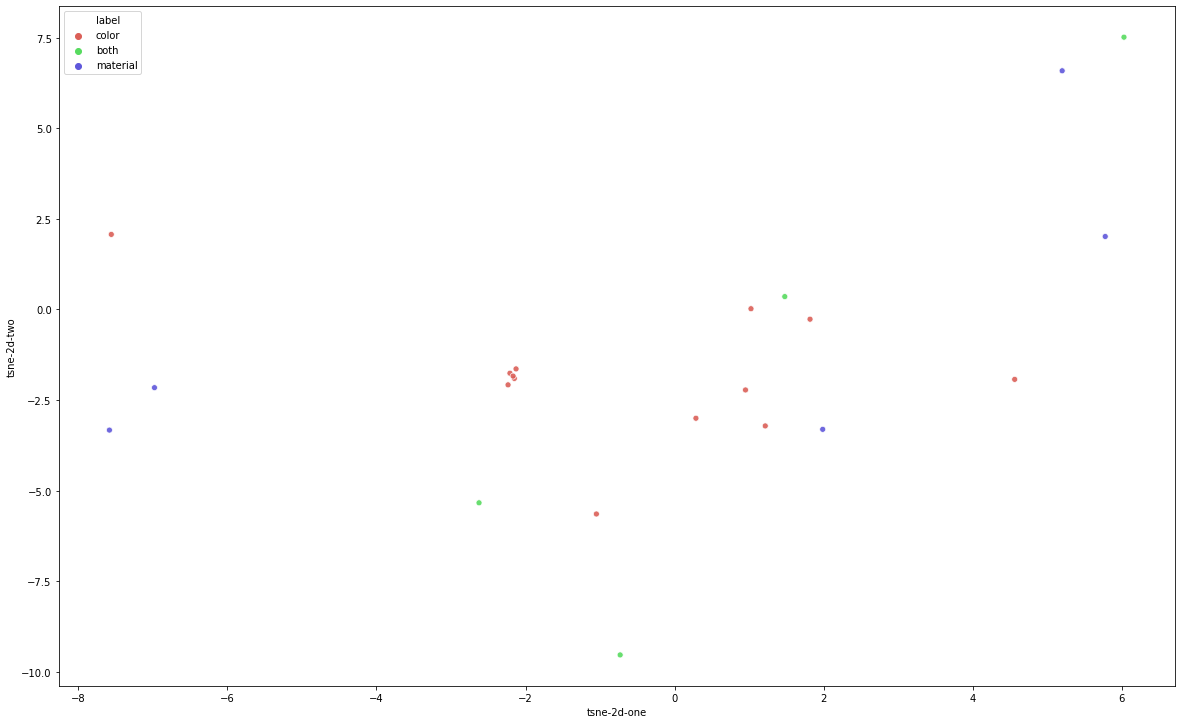

In [0]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df_for_plot = df[df.label != 'other']
plt.figure(figsize=(20,12.5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 3),
    sizes=(2.5, 2.5, 2.5),
    data=df_for_plot,
    legend="brief",
    alpha=0.9
)